In [1]:
import torch
import torchvision
import torchbearer

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import itertools

import os
import datetime

import glob
import matplotlib.pyplot as plt
import numpy as np

import livelossplot

In [2]:
from cure_dataset import *
from cure_models import *

In [83]:
from cure_utils import *

In [69]:
import importlib

In [82]:
import cure_utils
importlib.reload(cure_utils)

<module 'cure_utils' from '/home/ubuntu/project/cure_utils.py'>

# Setup Data import

In [4]:
load_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor(),
    l2normalize,
    standardization
])

In [36]:
load_raw = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor()])

# Training on the clean data

In [5]:
save_directory = 'checkpoints'

In [6]:
# load real and unreal challenge free images 
testdataset = CURETSRDataset('../data', 'Test', '*', '00', '00', transform=load_transform)
traindataset = CURETSRDataset('../data', 'Train', '*', '00', '00', transform=load_transform)

In [7]:
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=128,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=500,
                                          shuffle=False, num_workers=2)

In [8]:
print("Train Length:", len(traindataset),"\nTest Length:", len(testdataset))

Train Length: 26902 
Test Length: 11544


In [9]:
clear_model = ShallowNetwork().cuda()

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clear_model.parameters(), lr=.001, amsgrad=True)

In [12]:
checkpoint_name = os.path.join(save_directory, 'shallowCNN.{epoch:02d}-{val_acc:.3f}.pt')
callbacks = [torchbearer.callbacks.LiveLossPlot(), torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
trial = torchbearer.Trial(clear_model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
    train_generator=trainloader,
    val_generator=testloader
).cuda()

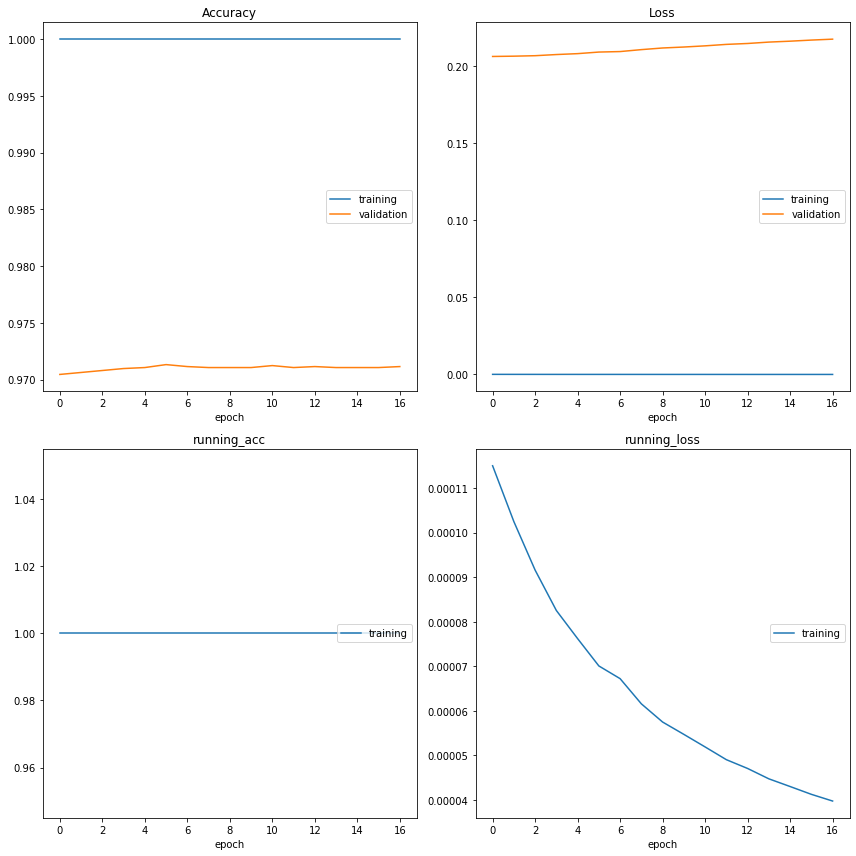

KeyboardInterrupt: 

In [14]:
history = trial.run(epochs=50)

In [10]:
# load highest checkpoint value

clear_model.load_state_dict(torch.load('checkpoints/shallowCNN.25-0.971.pt')['model'], strict=False)

<All keys matched successfully>

Confusion matrix, without normalization
[[ 743    1    0    0    0    0    4    4    1    3    2    0    0    1]
 [   0  620    0    0    1    0    0    0    0    0    0    0    0    3]
 [   0    0  432    0    0    0    0    0    0    0    0    0    0    5]
 [   1    0    0  834   16    0   27    1    1    2    0    0    0    0]
 [   4    5    0    6  951    3   21    2    1    0    0    0    0    5]
 [   0    0    0    1    0 1161    1    0    0    0    0   11    0    0]
 [   8    1    0    0   15    0  640    9    1    0    0    0    0   32]
 [   0    0    0    0    0    0    0  797    0    0    0    0    7    7]
 [   0    0    0    0    0    0    0    0  616    0    0    0    2    1]
 [  32    0    0    0    2    0    0    0    1  704    0    0    7   15]
 [   0    0    0    0    0    0    0    0    0    1  445    0    0    0]
 [   0    0    0    0    2    1    0    0    0    0    0  268    0    7]
 [   5    0    0    0    3    0    1    1    0    1    0    0  845   22]
 [   2    1

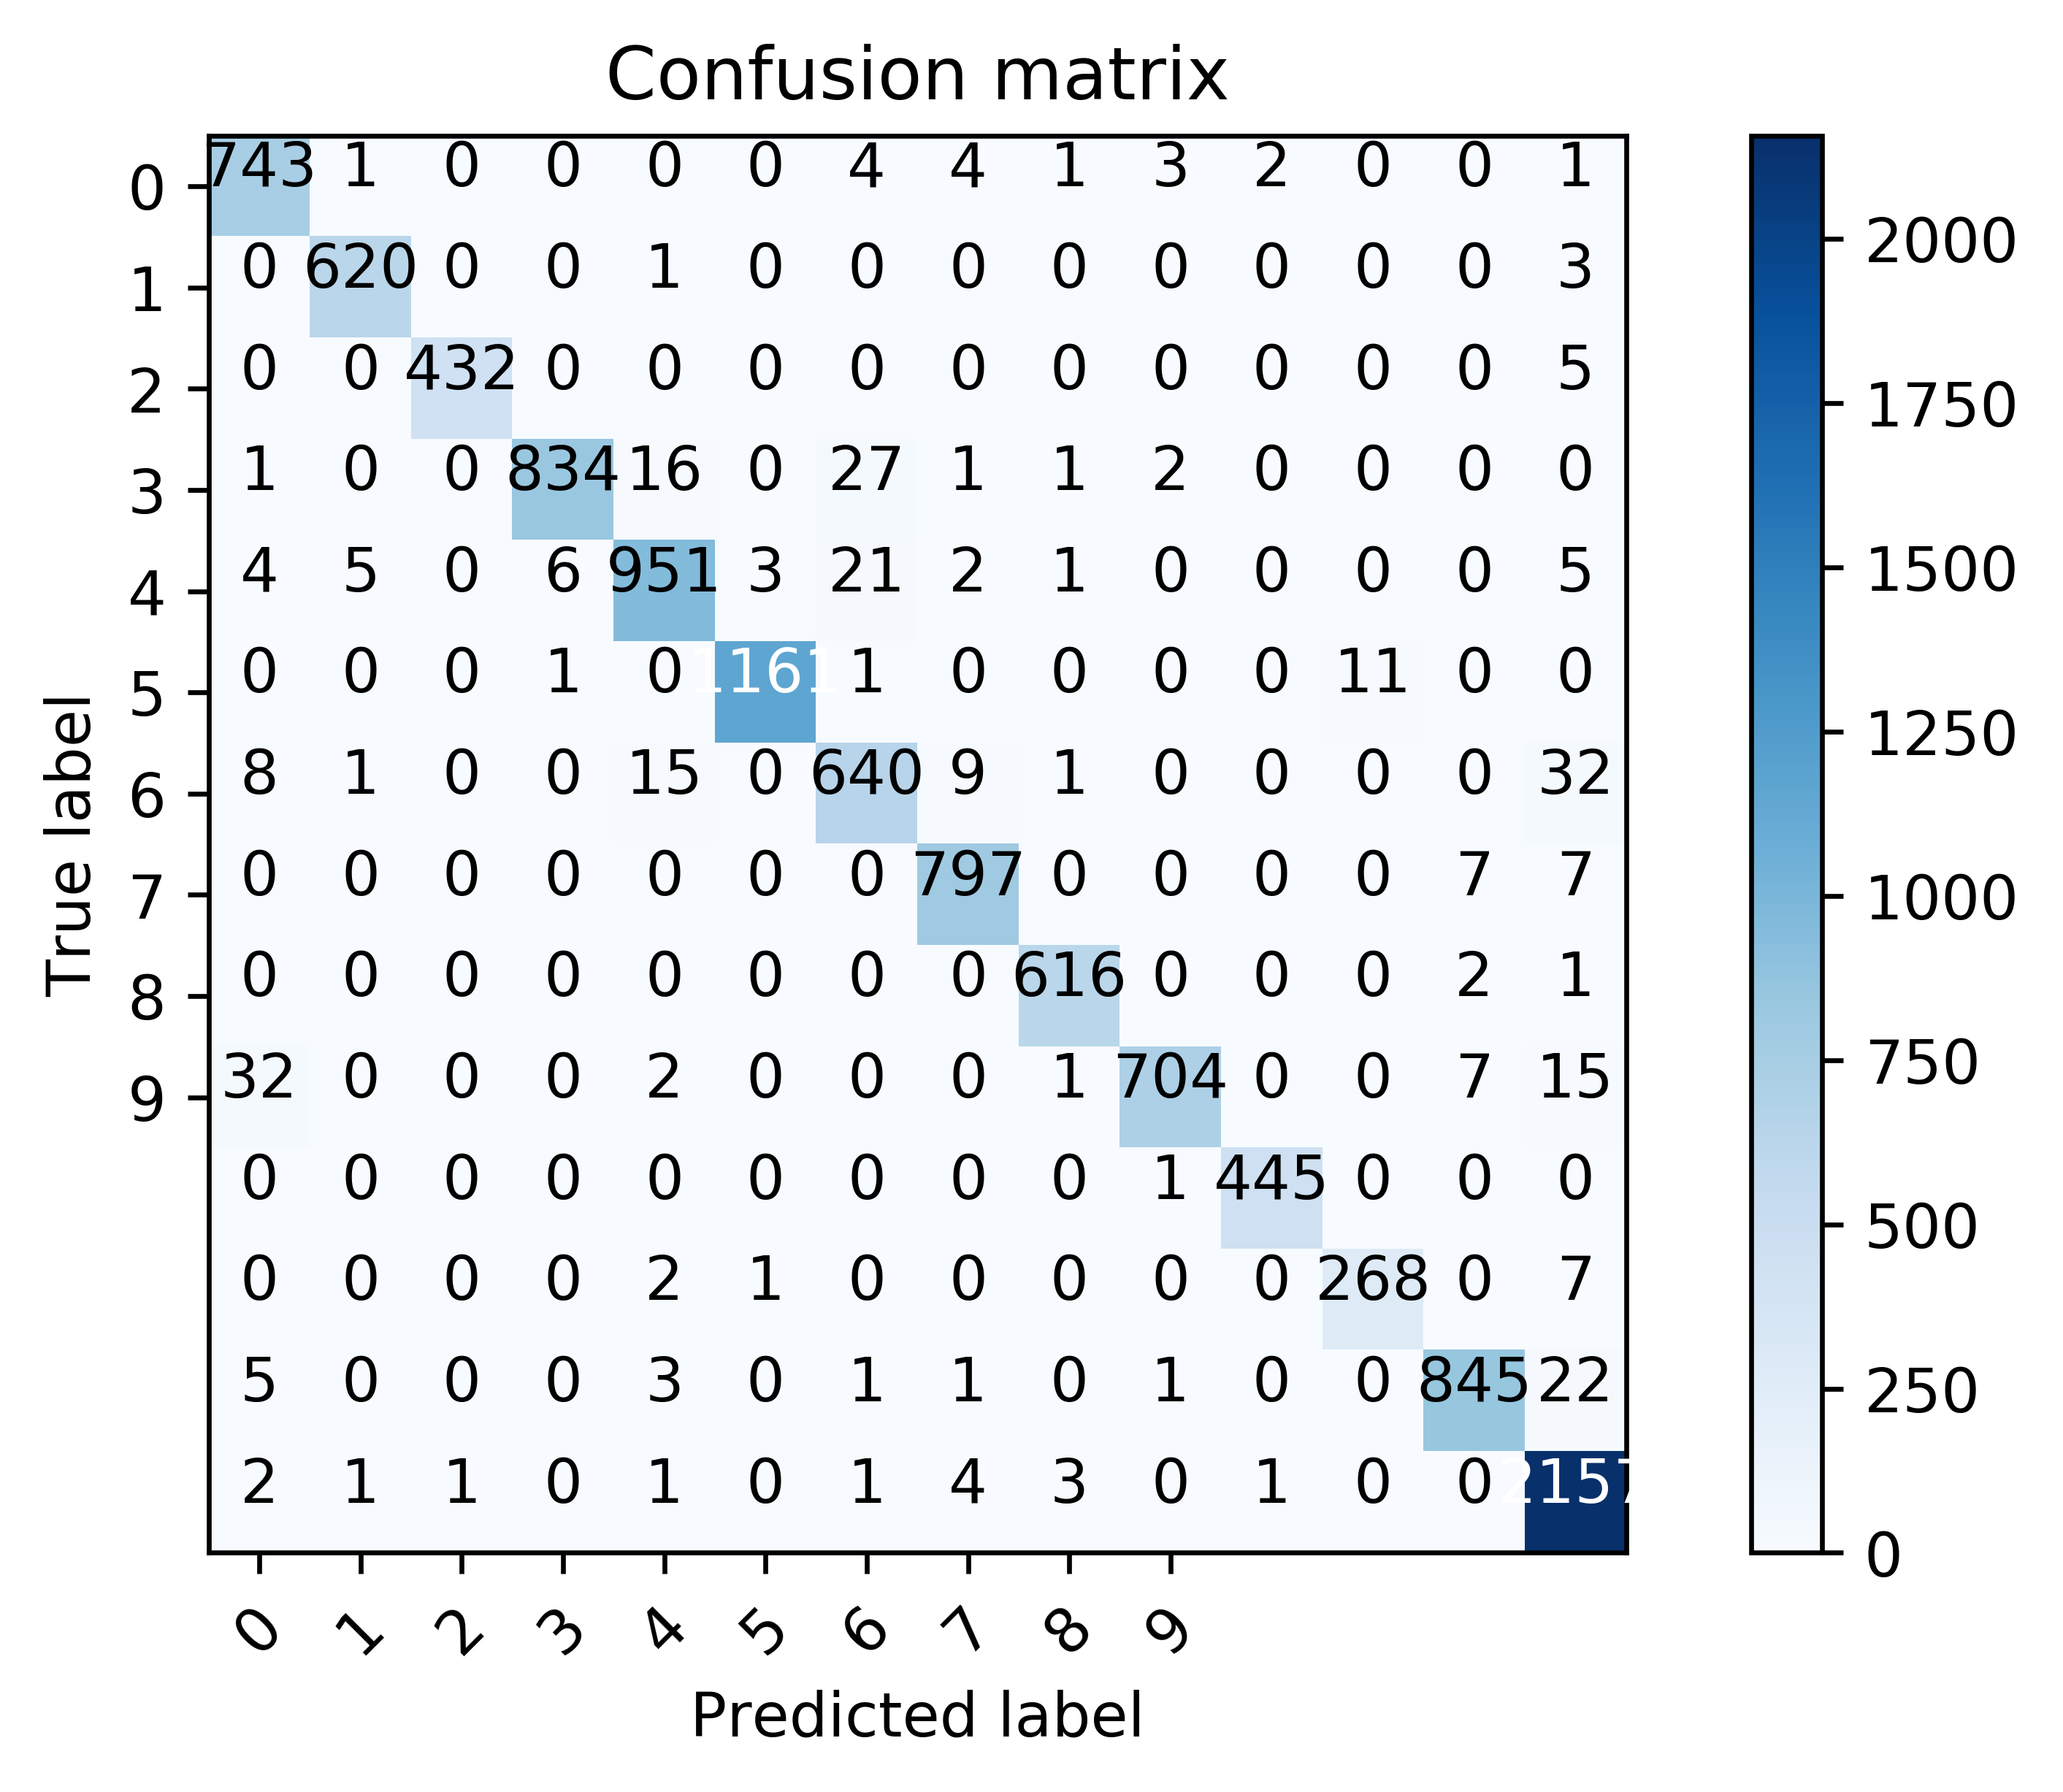

In [11]:
evaluate_model(clear_model, testloader)

# Train on exposure Challenge Data

In [37]:
# load real and unreal challenge free images 
exposure_testdataset = CURETSRDataset('../data', 'Test', '*', '06', '*', transform=load_raw)
exposure_traindataset = CURETSRDataset('../data', 'Train', '*', '06', '*', transform=load_raw)

exposure_train = torch.utils.data.DataLoader(exposure_traindataset, batch_size=128,
                                          shuffle=False, num_workers=2)
exposure_test = torch.utils.data.DataLoader(exposure_testdataset, batch_size=500,
                                          shuffle=False, num_workers=2)

In [8]:
print(len(exposure_train.dataset), len(exposure_test.dataset))

134510 57720


In [38]:
exposure_model = ShallowNetwork().cuda()

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(exposure_model.parameters(), lr=.001, amsgrad=True)

In [40]:
checkpoint_name = os.path.join(save_directory, 'shallowCNN_exposure.{epoch:02d}-{val_acc:.3f}.pt')
callbacks = [torchbearer.callbacks.LiveLossPlot(), torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
trial = torchbearer.Trial(exposure_model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
    train_generator=exposure_train,
    val_generator=exposure_test
).cuda()

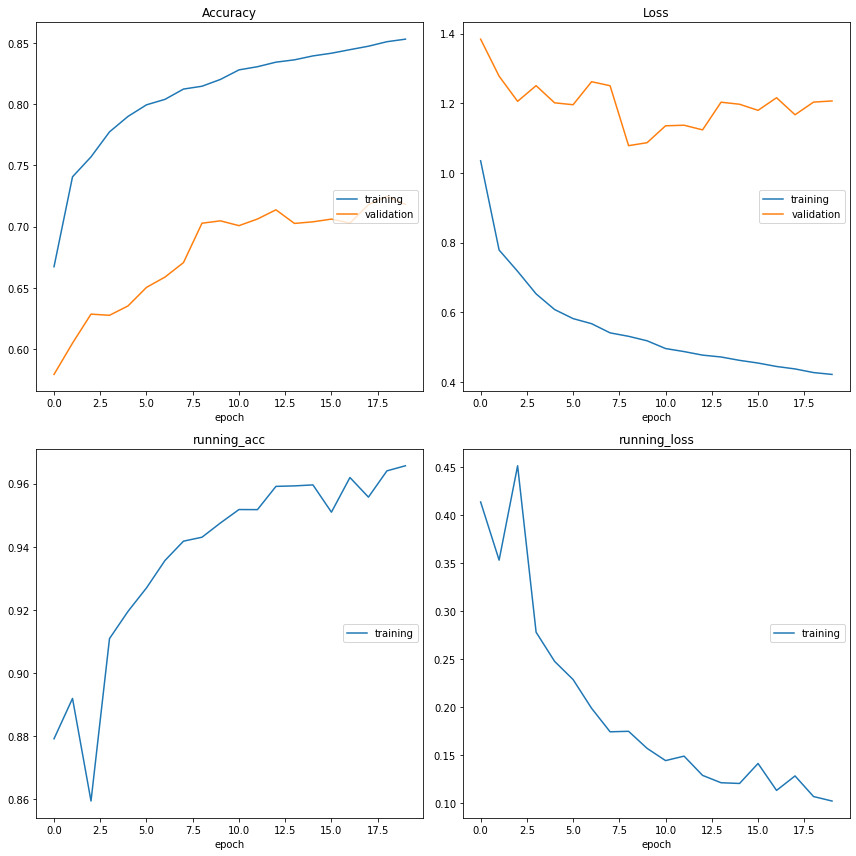

In [41]:
history = trial.run(epochs=20)

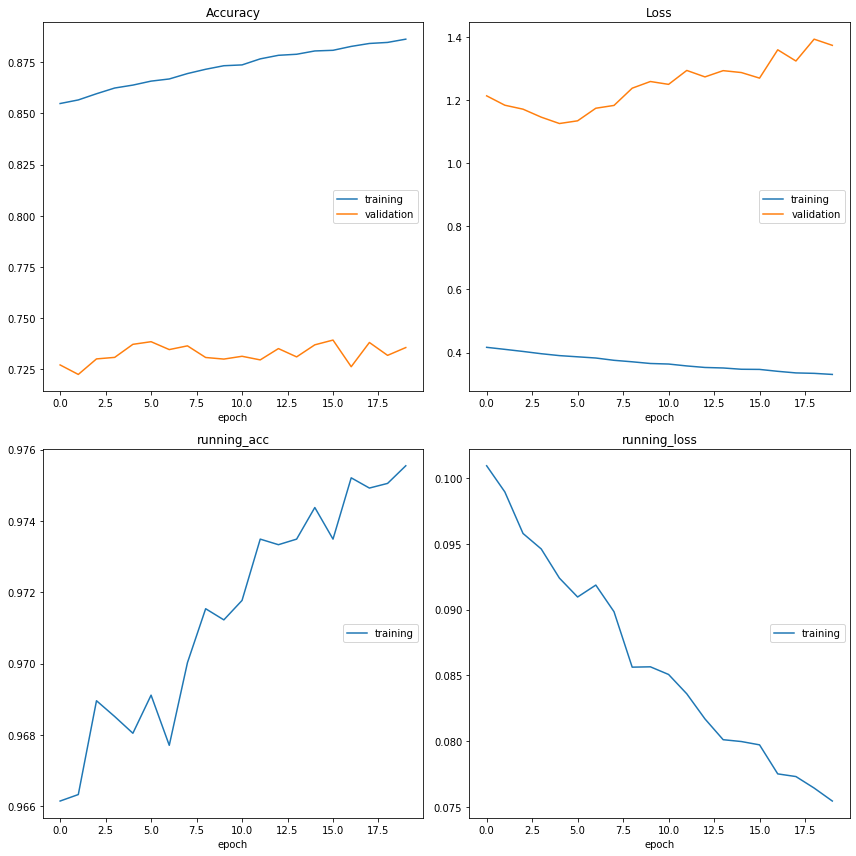

In [42]:
history = trial.run(epochs=40)

In [56]:
trial = torchbearer.Trial(ShallowNetwork()).load_state_dict(torch.load('checkpoints/shallowCNN_exposure.35-0.739.pt'))


In [49]:
trial.state[torchbearer.CALLBACK_LIST] = []

In [60]:
exposure_testdataset = CURETSRDataset('../data', 'Test', '01', '07', '01', transform=load_transform)
exposure_test = torch.utils.data.DataLoader(exposure_testdataset, batch_size=500,
                                          shuffle=False, num_workers=2)



In [73]:
len(exposure_test.dataset)

3334

In [75]:
from collections import Counter

c = Counter()

for _, labels in exposure_test:
    c.update([label.item() for label in labels])
    
c

Counter({0: 538,
         11: 43,
         4: 372,
         13: 1195,
         9: 314,
         1: 65,
         12: 269,
         6: 386,
         7: 92,
         5: 44,
         3: 16})

In [61]:
trial.with_val_generator(exposure_test)
out = trial.evaluate()

Confusion matrix, without normalization
[[347   0   0   0  19   0   0  22   0  63   1  41  45]
 [  2  22   0   2   3   0   0   0   0   0  29   5   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   2   9   0   0   1   0   0   0   2   1]
 [  2   0   1   3 346   0   9   0   0   0   1   0  10]
 [  0   0   0   0   3  41   0   0   0   0   0   0   0]
 [  4   0   1   0 150   0 112   9   0   2  18  23  67]
 [  0   0   0   0   0   0   0  91   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 49   0   0   4  50   0   3   5   0 162   0  38   3]
 [  0   0   0   0   3   0   7  10   0   1  13   5   4]
 [  0   0   0   0  11   0   1   1   0   0   0 232  24]
 [  3   9   0   0  71   0  14  76   3  12  28 240 739]]
Accuracy of the network on the test images: 63.197 %
Accuracy of     0 (538) : 64.498 %
Accuracy of     1 (65) : 33.846 %
Accuracy of     2 (0): N/A
Accuracy of     3 (16) : 12.500 %
Accuracy of     4 (372) : 93.011 %
Accuracy of     5 (44) : 9

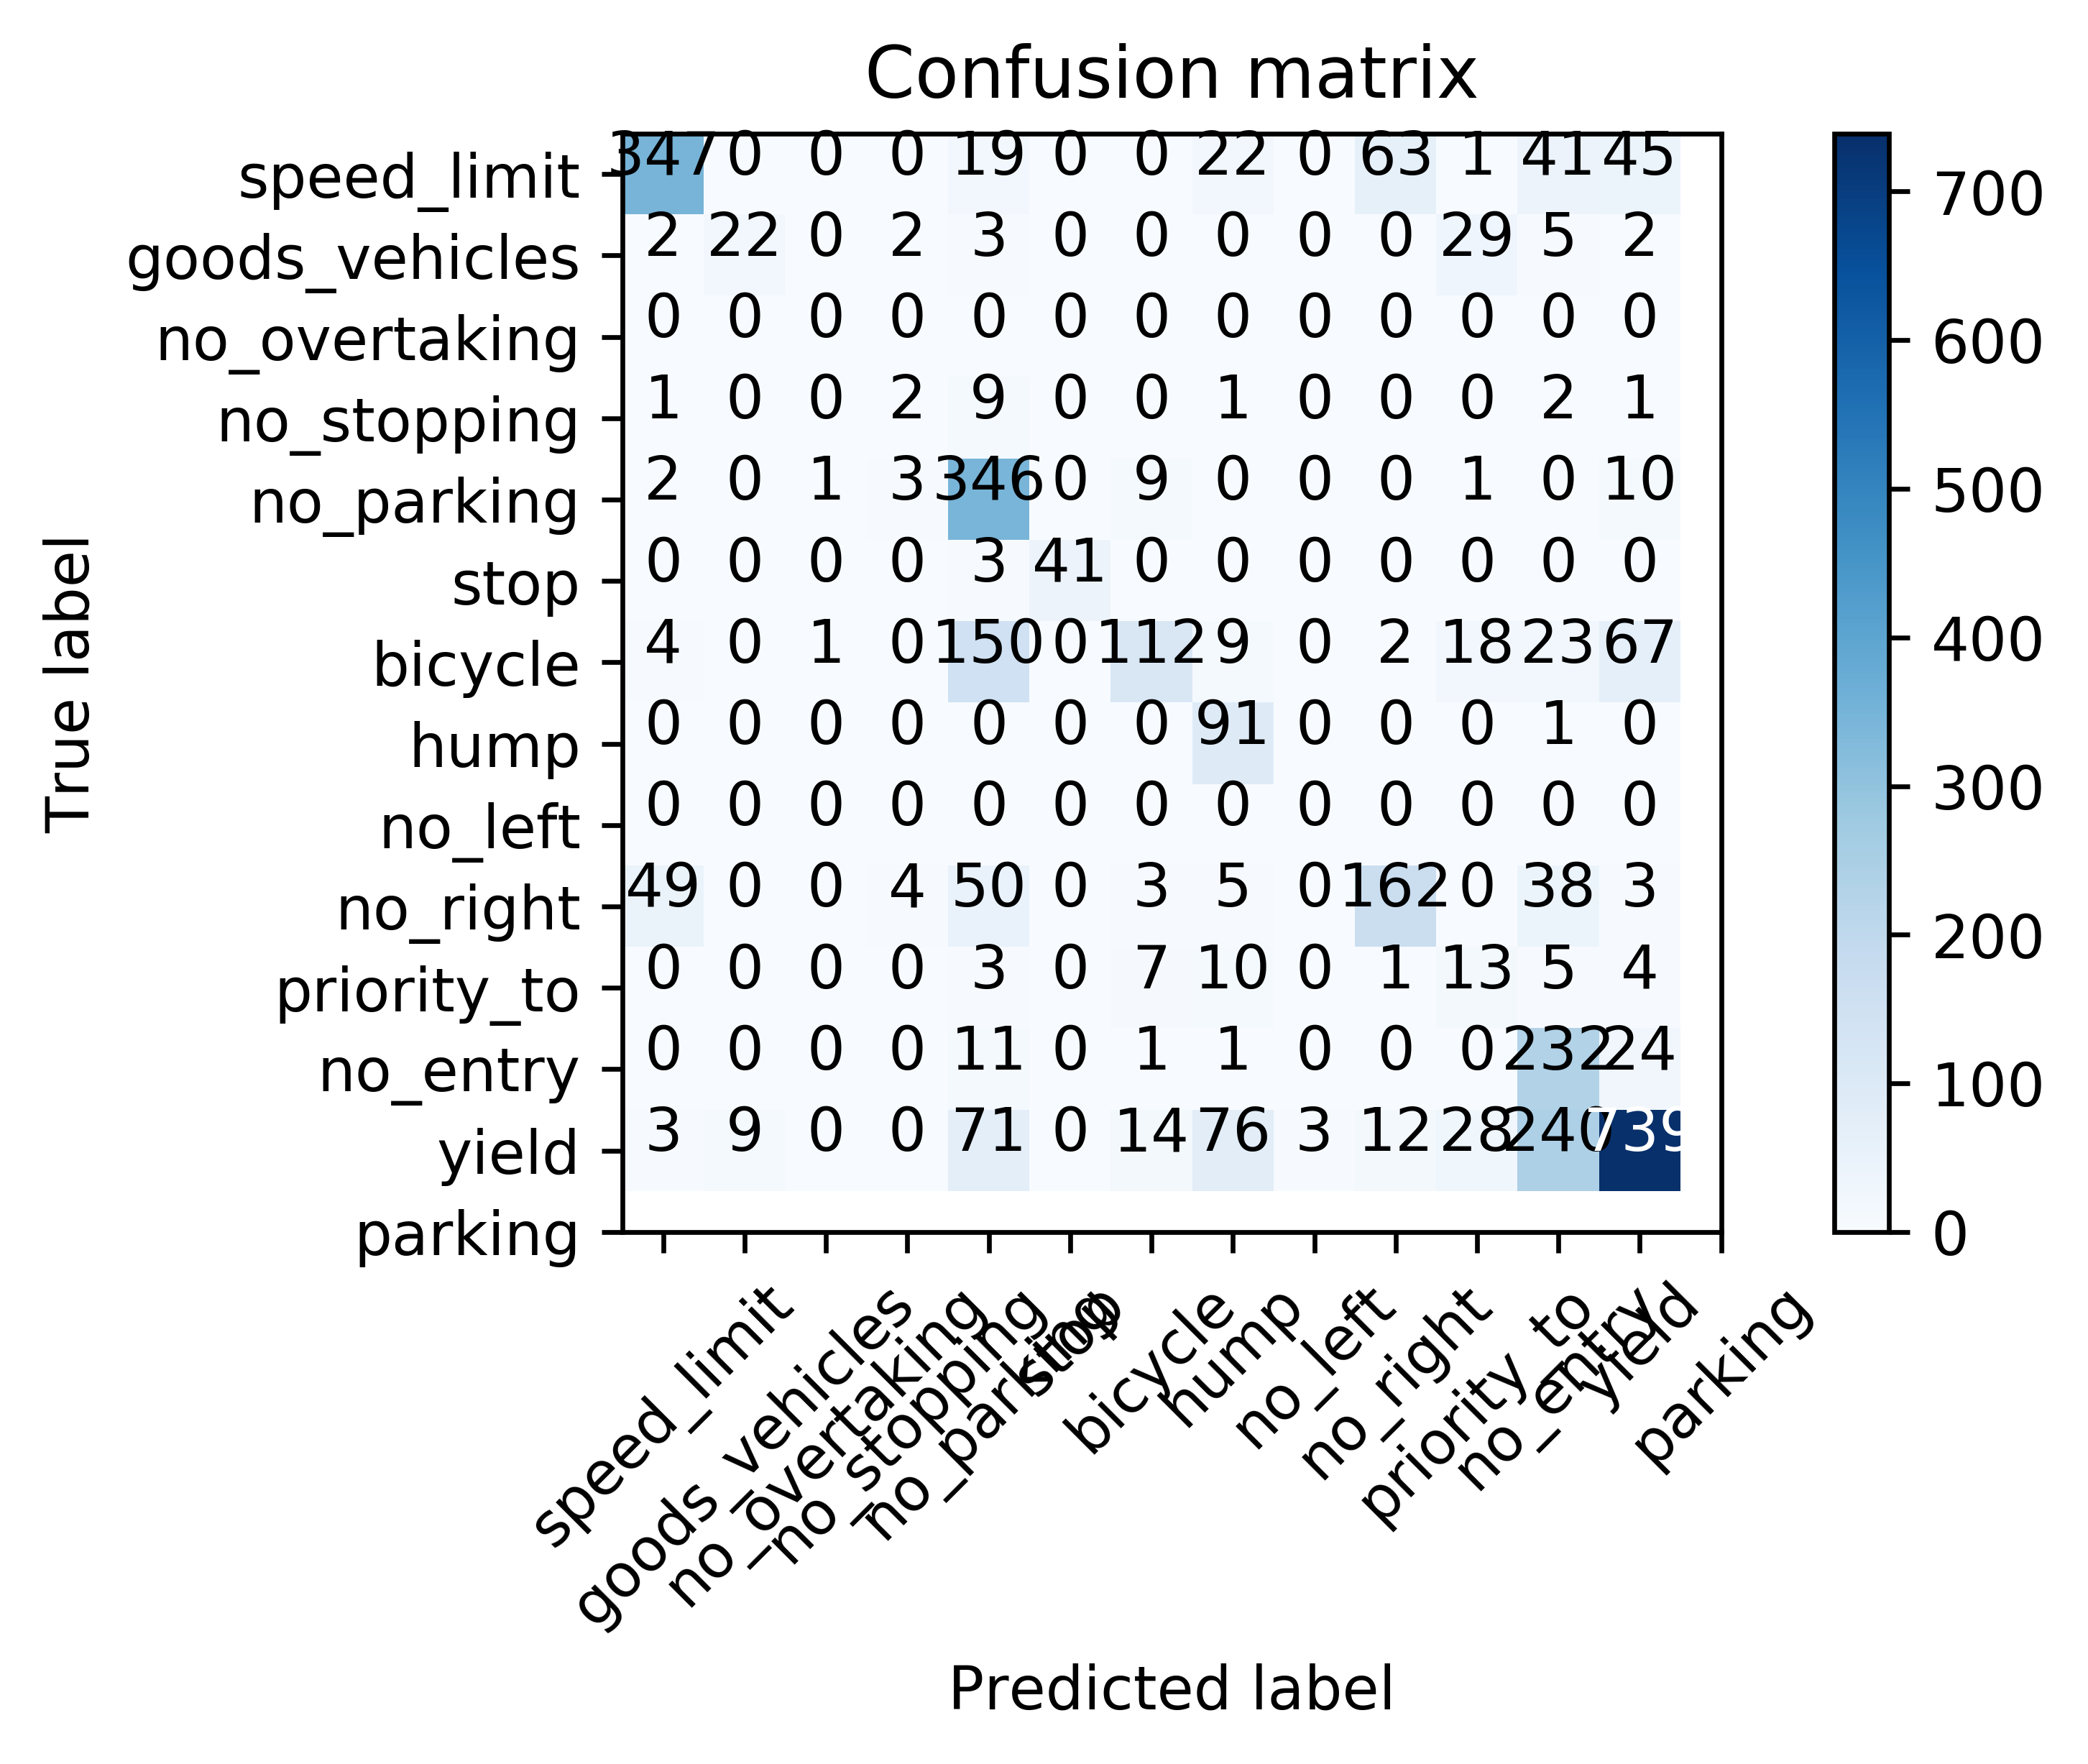

In [84]:
evaluate_model(exposure_model, exposure_test)

In [21]:
images, labels = iter(exposure_train).next()

In [26]:
def correct_image(im):
    return im.numpy().swapaxes(0,2).swapaxes(0,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8

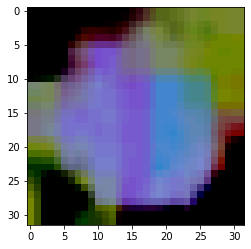

In [35]:
plt.imshow(correct_image(images[3]).astype(float))
labels[3].item()

# Train expert on darkening

In [ ]:
# load real and unreal challenge free images 
darkening_testdataset = CURETSRDataset('../data', 'Test', '*', '07', '*', transform=load_transform)
darkening_traindataset = CURETSRDataset('../data', 'Train', '*', '07', '*', transform=load_transform)

exposure_train = torch.utils.data.DataLoader(exposure_traindataset, batch_size=128,
                                          shuffle=False, num_workers=2)
exposure_test = torch.utils.data.DataLoader(exposure_testdataset, batch_size=500,
                                          shuffle=False, num_workers=2)